> E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

> E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [156]:
import torch

if torch.backends.mps.is_available():
    # not sure why, the mps device is even slower than the cpu device on my MacBook m1 machine
    # device = torch.device('mps')
    device = torch.device('cpu')
else:
    device = torch.device('cpu')

device

device(type='cpu')

# Load data

In [157]:
words = open('../../../data/names.txt', 'r').read().splitlines()

In [158]:
g = torch.Generator().manual_seed(2147483647)
trainwords, devwords, testwords = torch.utils.data.random_split(words, [0.8, 0.1, 0.1])

In [159]:
class Dataset:
    def __init__(self, dataset, context_size: int = 3):
        # create character - index mapping
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        # digitize the dataset
        xs, ys = [], []

        for w in dataset:
            context = [0] * context_size

            for ch in w + '.':
                ix = self.stoi[ch]
                xs.append(context)
                ys.append(ix)
                context = context[1:] + [ix]

        self.xs = torch.tensor(xs, device=device)
        self.ys = torch.tensor(ys, device=device)

    def __len__(self):
        return len(self.xs)
    
    def draw(self, batch_size: int = 32):
        ix = torch.randint(0, len(self), (batch_size,)).to(device)
        return(self.xs[ix], self.ys[ix])

In [160]:
trainset = Dataset(trainwords)
devset = Dataset(devwords)
testset = Dataset(testwords)

# MLP language model with `Batchnorm`

## Modules

In [161]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = (torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5).to(device)
    self.bias = (torch.zeros(fan_out).to(device) if bias else None)
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [162]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim).to(device)
    self.beta = torch.zeros(dim).to(device)
    
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim).to(device)
    self.running_var = torch.ones(dim).to(device)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance

    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [163]:
class Tanh:
  def __init__(self):
    pass
  
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

## Language model

In [164]:
import sys

def progress_bar(percent: float, bar_len: int = 20, front_str: str = '', back_str: str = ''):
    sys.stdout.write("\r")
    sys.stdout.write("{}[{:<{}}] {:.1%}{}".format(front_str, "=" * int(bar_len * percent), bar_len, percent, back_str))
    sys.stdout.flush()
    # avoiding '%' appears when progress completed
    if percent == 1:
        print()

In [165]:
import numpy as np
import matplotlib.pyplot as plt

def loss_curve(loss_ls):
    plt.plot(np.reshape(loss_ls, (-1,)))
    plt.xlabel('epoch')
    plt.ylabel('cross entropy')
    plt.grid('--')

In [166]:
import torch.nn.functional as F

class LM_batchnorm(object):
    def __init__(
            self,
            itos,
            vocab_size = 27, # token vocabulary size
            context_size = 3, # context length: how many characters do we take to predict the next one
            embed_size = 10, # the dimensionality of the character embedding vectors
            hidden_size = 100, # the number of neurons in the hidden layer of the MLP
        ):
        self.itos = itos
        self.context_size = context_size
        g = torch.Generator().manual_seed(2147483647)

        # parameter initialization
        # token embeddings
        self.C = torch.randn((vocab_size, embed_size), generator=g).to(device)
        
        # stacked layers
        self.layers = [
            Linear(embed_size * self.context_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            Linear(hidden_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
            Linear(hidden_size, vocab_size, bias=False), BatchNorm1d(vocab_size),
        ]

        with torch.no_grad():
            # last layer: make less confident
            self.layers[-1].gamma *= 0.1
        
            # all other self.layers: apply gain
            for layer in self.layers[:-1]:
                if isinstance(layer, Linear):
                    layer.weight *= 1.0 #5/3

        # gather all parameters
        self.param = [self.C] + [p for layer in self.layers for p in layer.parameters()]
        print("param num: {}".format(sum(p.nelement() for p in self.param)))

    def forward(self, xs):
        emb = self.C[xs] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors

        for layer in self.layers:
            x = layer(x)

        return x
    
    def switch_mode(self, mode = 'train'):
        if mode == 'train':
            for layer in self.layers:
                if isinstance(layer, BatchNorm1d):
                    layer.training = True

        else:
            for layer in self.layers:
                if isinstance(layer, BatchNorm1d):
                    layer.training = False

    def train(self, dataset, batch_size: int = 32, epochs: int = 1000, lr: float = 1e-1):
        for p in self.param:
            p.requires_grad = True

        loss_ls = []
        update_ls = []
        self.switch_mode('train')

        for ix in range(epochs):
            progress_bar((ix+1) / epochs, back_str="\t learning rate {}".format(lr))

            # batch forward/backward pass
            xs_batch, ys_batch = dataset.draw(batch_size)
            logits = self.forward(xs_batch)
            loss = F.cross_entropy(logits, ys_batch)

            # gradient descent
            for layer in self.layers:
                layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
            
            for p in self.param:
                p.grad = None
            
            loss.backward()
            
            if ix < 150000:
                for p in self.param:
                    p.data += -lr * p.grad
            else:
                for p in self.param:
                    p.data += -lr/10 * p.grad # step learning rate decay

            # track stats
            loss_ls.append(loss.item())

            with torch.no_grad():
                update_ls.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in self.param])

        return loss_ls, update_ls

    def eval(self, dataset, loss_str: str = ''):
        self.switch_mode('infer')
        xs, ys = dataset.xs, dataset.ys
        logits = self.forward(xs)
        loss = F.cross_entropy(logits, ys)
        print("{} \t {:.4f}".format(loss_str, loss.item()))

    def sample(self, sample_num: 1):
        self.switch_mode('infer')
        
        for _ in range(sample_num):
            out = []
            context = [0] * self.context_size # initialize with all ...

            while True:
                # forward pass the neural net
                logits = self.forward(torch.tensor([context]))
                probs = F.softmax(logits, dim=1)

                # sample from the distribution
                ix = torch.multinomial(probs, num_samples=1, generator=g).item()
                
                # shift the context window and track the samples
                context = context[1:] + [ix]
                out.append(ix)
                # if we sample the special '.' token, break
                if ix == 0:
                    break
            
            print(''.join(self.itos[i] for i in out[:-1])) # decode and print the generated word

In [ ]:
class 

param num: 173724
[====================] 100.0%	 learning rate 0.1


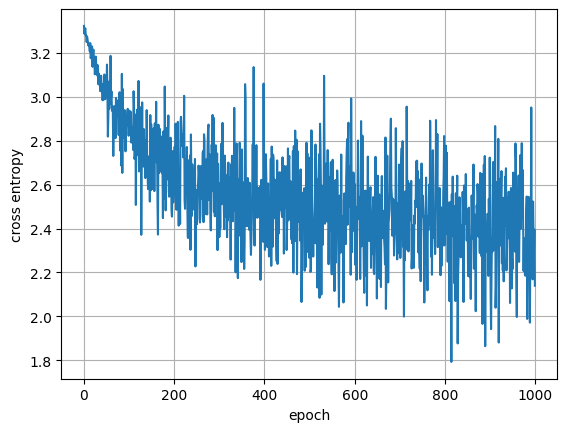

In [176]:
# model init
lm = LM_batchnorm(
    itos = trainset.itos,
    context_size = 3,
    embed_size = 10,
    hidden_size = 200,
    )

# train
loss_ls, update_ls = lm.train(trainset, epochs=1000)
loss_curve(loss_ls)

# Network status visualization

## Activation of layers

	 layer 2 (Tanh) 	 mean -0.00 	 std 0.64 	 saturated: 2.38%
	 layer 5 (Tanh) 	 mean -0.00 	 std 0.64 	 saturated: 2.52%
	 layer 8 (Tanh) 	 mean 0.00 	 std 0.65 	 saturated: 2.00%
	 layer 11 (Tanh) 	 mean -0.00 	 std 0.64 	 saturated: 2.14%
	 layer 14 (Tanh) 	 mean 0.00 	 std 0.65 	 saturated: 1.59%


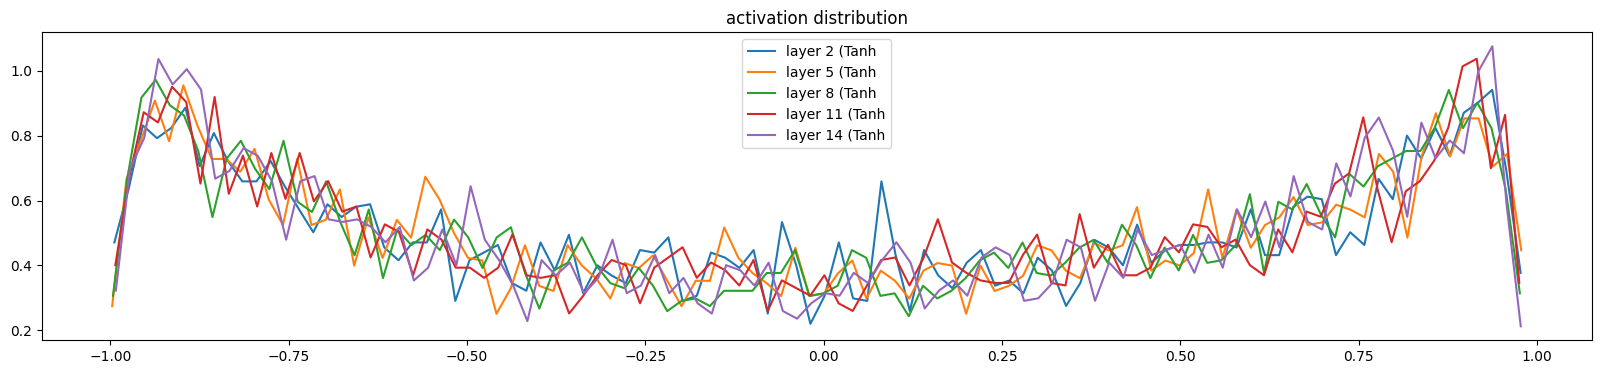

In [177]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(lm.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print("\t layer {} ({}) \t mean {:.2f} \t std {:.2f} \t saturated: {:.2f}%".format(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append("layer {} ({}".format(i, layer.__class__.__name__))

plt.legend(legends)
plt.title('activation distribution')
plt.show()

## Gradient of layers

	 layer 2 (Tanh) 	 mean 0.00 	 std 1.64e-03
	 layer 5 (Tanh) 	 mean -0.00 	 std 1.31e-03
	 layer 8 (Tanh) 	 mean -0.00 	 std 1.18e-03
	 layer 11 (Tanh) 	 mean 0.00 	 std 1.07e-03
	 layer 14 (Tanh) 	 mean -0.00 	 std 1.03e-03


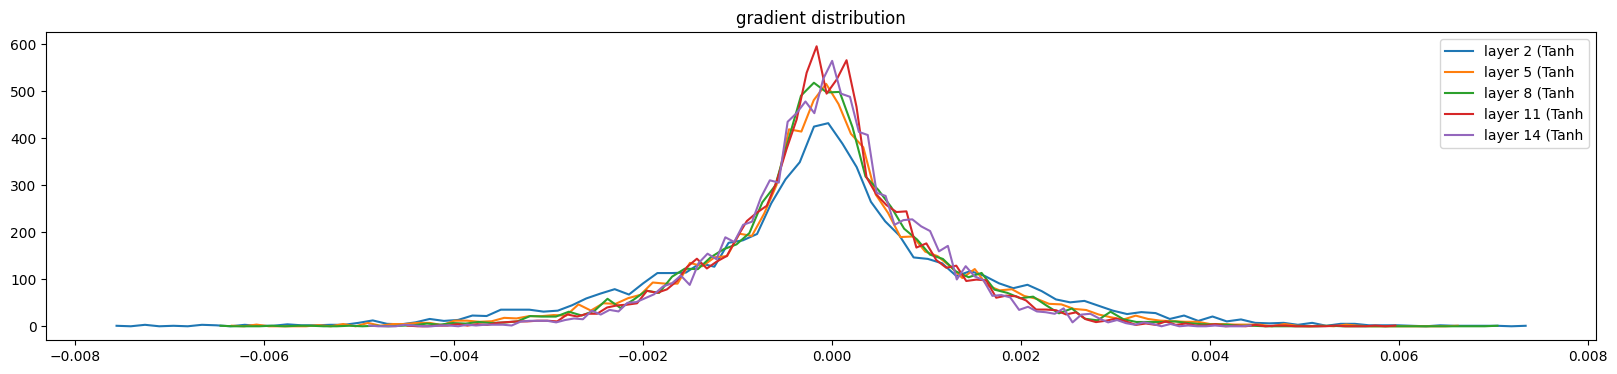

In [178]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(lm.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print("\t layer {} ({}) \t mean {:.2f} \t std {:.2e}".format(i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append("layer {} ({}".format(i, layer.__class__.__name__))

plt.legend(legends)
plt.title('gradient distribution')
plt.show()

## Update scale of layers

	 weight (27, 10) 	 mean -0.00 	 std 8.76e-03 	 grad:data ratio 8.75e-03
	 weight (30, 200) 	 mean 0.00 	 std 6.57e-03 	 grad:data ratio 3.58e-02
	 weight (200, 200) 	 mean -0.00 	 std 4.47e-03 	 grad:data ratio 6.20e-02
	 weight (200, 200) 	 mean 0.00 	 std 3.54e-03 	 grad:data ratio 4.94e-02
	 weight (200, 200) 	 mean 0.00 	 std 3.21e-03 	 grad:data ratio 4.48e-02
	 weight (200, 200) 	 mean -0.00 	 std 2.90e-03 	 grad:data ratio 4.06e-02
	 weight (200, 27) 	 mean 0.00 	 std 7.68e-03 	 grad:data ratio 1.03e-01


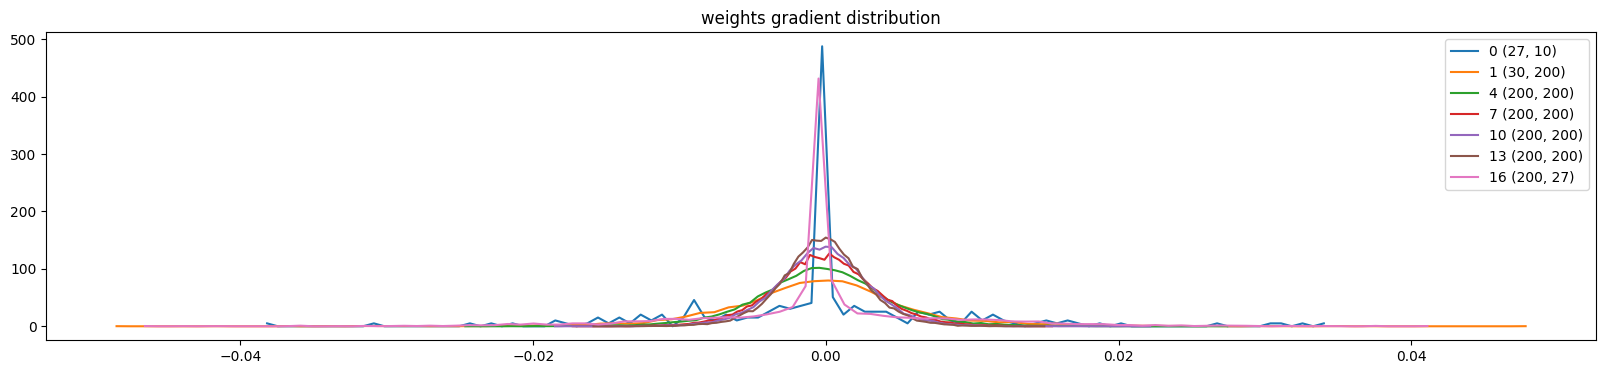

In [179]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i,p in enumerate(lm.param):
  t = p.grad

  if p.ndim == 2:
    print("\t weight {} \t mean {:.2f} \t std {:.2e} \t grad:data ratio {:.2e}".format(tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append("{} {}".format(i, tuple(p.shape)))

plt.legend(legends)
plt.title('weights gradient distribution')
plt.show()

## Update scale over time

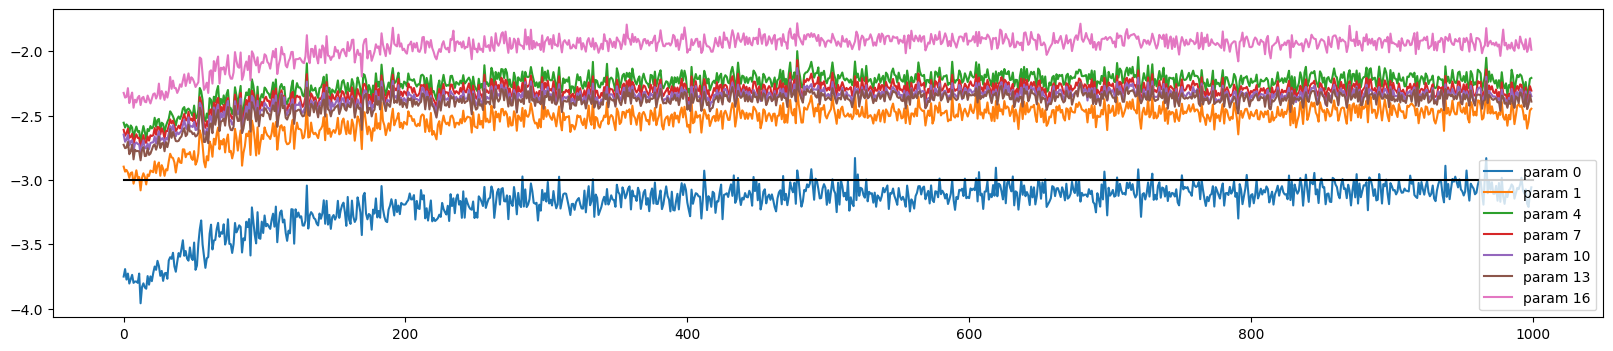

In [180]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(lm.param):
  if p.ndim == 2:
    plt.plot([update_ls[j][i] for j in range(len(update_ls))])
    legends.append('param {}'.format(i))

plt.plot([0, len(update_ls)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.show()

# Evaluation

In [181]:
lm.eval(trainset, loss_str='train')
lm.eval(devset, loss_str='dev')
lm.eval(testset, loss_str='test')

train 	 2.3830
dev 	 2.3988
test 	 2.3863


In [182]:
lm.sample(10)

kanoaltiy
agguy
hwma
bren
mpi
kinxste
jarlania
lie
havonuare
sampnlarin
